## Импорт библиотек и модулей :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings as wr

## Объявление постоянных значений и констант :

In [2]:
RANDOM_STATE = 125 # для фиксирования результатов
METRICS = ["accuracy","roc_auc","f1","recall"] # рассматриваемые метрики
MODELS = [LogisticRegression, DecisionTreeClassifier, SVC, RandomForestClassifier] # иследование нескольких моделей

# игнорирогвание предупреждений
wr.filterwarnings('ignore')
wr.simplefilter('ignore')

## Написание используемых функций : 

Функция чтения данных:

In [3]:
def read_data(path_str):
    new_columns = ["survival","still-alive","age-at-heart-attack","pericardial-effusion","fractional-shortening",\
                   "epss","lvdd","wall-motion-score","wall-motion-index","mult","name","group","alive-at-1"]
    df = pd.read_csv(path_str, sep=",", names = new_columns )
    df.replace({"?":np.NaN}, inplace=True)
    column_drop = ["mult","group","name"]
    df = df.drop(column_drop, axis=1)
    df = df.astype(float)
    data = df[~df["alive-at-1"].isnull()]
    data_nan = df[df["alive-at-1"].isnull()]
    if (len(data[data.isnull().any(1)])>0):
        for colum in list(data.columns):
            data.loc[data[colum].isnull(), colum] = data[colum].median() 
    return df
    

Функции предобработки данных:

In [4]:
def pred_procesing_data(df):
    data = df.copy()
    if (len(data[data.isnull().any(1)])>0):
        for colum in list(data.columns):
            if colum != "alive-at-1":
                data.loc[data[colum].isnull(), colum] = data[colum].median()
    data_nan = data[data["alive-at-1"].isnull()]
    data = data[~data["alive-at-1"].isnull()]
    return data, data_nan

In [5]:
def pred_procesing_data_2(df):
    data = df.copy()
    if (len(data[data.isnull().any(1)])>0):
        for colum in list(data.columns):
            if colum != "alive-at-1":
                data.loc[data[colum].isnull(), colum] = data[colum].median()
    data.loc[data["still-alive"]==0, "alive-at-1"] = 0
    data_nan = data[data["alive-at-1"].isnull()]
    data = data[~data["alive-at-1"].isnull()]
    return data, data_nan

Функция вывода графика результатов по метрике на большой или малой выборке:

In [6]:
from sklearn.metrics import get_scorer
from sklearn.model_selection import StratifiedKFold

def Print_REsult_scoring_metric(model, X, Y, Nsplits=5, Random_state=1346, metric = "roc_auc", lable=""):
    cv = StratifiedKFold(n_splits=Nsplits, shuffle=True, random_state=Random_state)
    
    valid_scores_big_selection = np.array([])
    valid_scores_small_selection = np.array([])
    for indexBigChoise, indexSmallChoise in cv.split(X,Y):
        valid_scores_big_selection = np.append(
            valid_scores_big_selection, get_scorer(metric)(model,X[indexBigChoise],Y[indexBigChoise])
        )
        valid_scores_small_selection = np.append(
            valid_scores_small_selection, get_scorer(metric)(model,X[indexSmallChoise],Y[indexSmallChoise])
        )
    
    plt.title(lable+"\nBest_valid_scores_big_selection: "+str(round(valid_scores_big_selection.max(),6))+
              "\nBest_valid_scores_small_selection: "+str(round(valid_scores_small_selection.max(),6)))
    plt.xlabel("number_selection: "+str(Nsplits))
    plt.ylabel("valid_scores "+metric)
    
    plt.plot(range(0,Nsplits),valid_scores_big_selection, color="b", linewidth=2)
    plt.plot(range(0,Nsplits),valid_scores_small_selection, color="r", linewidth=2)

## Чтение и обработка данных :

Даны данные по кардиограмме сердца людей переживших или не пережившых инфаркт во время периода наблюдений и после него в течении года.

Памятка к данным:
ttribute Information:
   1. survival -- the number of months patient survived (has survived, if patient is still alive).  Because all the patients had their heart attacks at different times, it is possible that some patients have survived less than one year but they are still alive.  Check the second variable to confirm this.  Such patients cannot be used for the prediction task mentioned above.
   2. still-alive -- a binary variable.  0=dead at end of survival period, 1 means still alive 
   3. age-at-heart-attack -- age in years when heart attack occurred
   4. pericardial-effusion -- binary. Pericardial effusion is fluid around the heart.  0=no fluid, 1=fluid
   5. fractional-shortening -- a measure of contracility around the heart lower numbers are increasingly abnormal
   6. epss -- E-point septal separation, another measure of contractility. Larger numbers are increasingly abnormal.
   7. lvdd -- left ventricular end-diastolic dimension.  This is a measure of the size of the heart at end-diastole. Large hearts tend to be sick hearts.
   8. wall-motion-score -- a measure of how the segments of the left ventricle are moving
   9. wall-motion-index -- equals wall-motion-score divided by number of segments seen.  Usually 12-13 segments are seen in an echocardiogram.  Use this variable INSTEAD of the wall motion score.
   10. mult -- a derivate var which can be ignored
   11. name -- the name of the patient (I have replaced them with "name")
   12. group -- meaningless, ignore it
   13. alive-at-1 -- Boolean-valued. Derived from the first two attributes. 0 means patient was either dead after 1 year or had been followed for less than 1 year.  1 means patient was alive at 1 year.
Missing Attribute Values: (denoted by "?")

Перевод:

Информация о атрибуте:
1. выживаемость (survival) - количество месяцев, в течение которых пациент выжил (выжил, если пациент все еще жив). Поскольку у всех пациентов сердечные приступы были в разное время, возможно, что некоторые пациенты пережили менее одного года, но они все еще живы. Проверьте вторую переменную, чтобы подтвердить это. Такие пациенты не могут быть использованы для упомянутой выше задачи прогнозирования.
2. все еще живой (still-alive) - двоичная переменная. 0 = мертв в конце периода выживания, 1 означает, что все еще жив
3. возраст на момент сердечного приступа (age-at-heart-attack) - возраст в годах, когда произошел сердечный приступ.
4. перикардиальный выпот (pericardial-effusion) - двоичный. Перикардиальный выпот представляет собой жидкость вокруг сердца. 0=жидкости нет, 1=жидкость
5. фракционное сокращение (fractional-shortening) - мера сократимости вокруг сердца более низкие цифры становятся все более ненормальными
6. epss - разделение межпозвоночной перегородки в точке E, еще один показатель сократимости. Большие цифры становятся все более ненормальными.
7. lvdd - конечный диастолический размер левого желудочка. Это мера размера сердца в конце диастолы. Большие сердца, как правило, являются больными сердцами.
8. оценка движения стены (wall-motion-score) - показатель того, как сегменты левой желудочек движется
9. индекс движения стены (wall-motion-index)- равен баллу движения стены, деленному на количество просмотренных сегментов. Обычно видно 12-13 сегментов на эхокардиограмме. Используйте эту переменную ВМЕСТО из оценки движения стены.
10. mult - производный var, который можно игнорировать
11. имя (name) - имя пациента (я заменил их на "имя")
12. группа (group) - бессмысленно, игнорируйте это
13. alive-at-1 - Логическое значение. Производный от первых двух атрибутов. 0 означает, что пациент либо умер через 1 год, либо находился под наблюдением менее 1 года. 1 означает, что пациент был жив в течение 1 года.
Отсутствующие значения атрибутов: (обозначаются символом "?")

In [7]:
df = read_data("echocardiogram_edit.csv")

display(df.head().T)
print(df.info())

,0,1,2,3,4
survival,11.00,19.00,16.00,57.000,19.00
still-alive,0.00,0.00,0.00,0.000,1.00
age-at-heart-attack,71.00,72.00,55.00,60.000,57.00
pericardial-effusion,0.00,0.00,0.00,0.000,0.00
fractional-shortening,0.26,0.38,0.26,0.253,0.16
epss,9.00,6.00,4.00,12.062,22.00
lvdd,4.60,4.10,3.42,4.603,5.75
wall-motion-score,14.00,14.00,14.00,16.000,18.00
wall-motion-index,1.00,1.70,1.00,1.450,2.25
alive-at-1,0.00,0.00,0.00,0.000,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               130 non-null    float64
 1   still-alive            131 non-null    float64
 2   age-at-heart-attack    127 non-null    float64
 3   pericardial-effusion   131 non-null    float64
 4   fractional-shortening  124 non-null    float64
 5   epss                   117 non-null    float64
 6   lvdd                   121 non-null    float64
 7   wall-motion-score      128 non-null    float64
 8   wall-motion-index      131 non-null    float64
 9   alive-at-1             74 non-null     float64
dtypes: float64(10)
memory usage: 10.4 KB
None


In [8]:
len(df[df["alive-at-1"].isnull()])

58

Иследовав описание к данным и просмотрев информацию о данном датасете, можно прийти к выводу о том что целевым полем является столбец alive-at-1, т.к. данный столбец сообщает нам о том что 1 означает, что пациент был жив в течение 1 года после периода наблюдений и 0 - иначе.
Проанализировав количество заполненных данных, мы видим что возможно данные были повреждены и часть, а именно 58 записей из столбца alive-at-1 были потеряны. Из этого складывается задача на основе известных данных научить какую либо из моделей определять эти значения и используя эту модель восстановить недостающие записи.

Исследуем какие значения может принимать данный столбец и при каких условиях. Из описания понятно, то что alive-at-1 и still-alive взаимо связвны, а именно still-alive сообщает о том что пациент пережил либо не пережил период наблюдений указанный в столбце survival, а в alive-at-1 пережил ли пациент в течении года после наблюдений. Поэтому alive-at-1 включает still-alive, однако только still-alive недостаточно для прогнозирования alive-at-1. 

In [9]:
display(df[df["still-alive"]==0][df["alive-at-1"]==1])

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1


Как видно из данной проверки пациентов которые уже не смогли пережить данный период, то в alive-at-1 уже не может стоять пережил.

In [10]:
display(df[df["still-alive"]==1][df["alive-at-1"]==0])

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
4,19.0,1.0,57.0,0.0,0.16,22.0,5.750,18.0,2.250,0.0
18,22.0,1.0,66.0,0.0,0.09,17.0,5.819,8.0,1.333,0.0
46,19.5,1.0,81.0,0.0,0.12,NaN,NaN,9.0,1.250,0.0
47,20.0,1.0,59.0,0.0,0.03,21.3,6.290,17.0,1.310,0.0
96,40.0,1.0,74.0,0.0,0.20,4.8,4.560,12.5,1.040,0.0


А вот при still-alive равному выжил и alive-at-1 равному не выжил, вполне возможно. Что говорит нам о том что если пациент пережил период наблюдений, это не гарантирует, что пациент прожил после этого более года.

In [11]:
display(df[df["still-alive"]==0][df["alive-at-1"]==0])

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,14.00,1.000,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,14.00,1.700,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,14.00,1.000,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,16.00,1.450,0.0
5,26.0,0.0,68.0,0.0,0.260,5.000,4.310,12.00,1.000,0.0
6,13.0,0.0,62.0,0.0,0.230,31.000,5.430,22.50,1.875,0.0
7,50.0,0.0,60.0,0.0,0.330,8.000,5.250,14.00,1.000,0.0
8,19.0,0.0,46.0,0.0,0.340,0.000,5.090,16.00,1.140,0.0
9,25.0,0.0,54.0,0.0,0.140,13.000,4.490,15.50,1.190,0.0
11,52.0,0.0,62.0,1.0,0.450,9.000,3.600,16.00,1.140,0.0


Рассмотрим более подробно данные через describe()

In [12]:
df.describe().drop(["25%","50%","75%"])

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
count,130.000000,131.000000,127.000000,131.000000,124.000000,117.000000,121.000000,128.000000,131.000000,74.000000
mean,22.182923,0.328244,62.925425,0.183206,0.216734,12.164769,4.763157,14.438125,1.382748,0.324324
std,15.858267,0.471377,8.403757,0.388320,0.107513,7.370159,0.810013,5.018566,0.453378,0.471317
min,0.030000,0.000000,35.000000,0.000000,0.010000,0.000000,2.320000,2.000000,1.000000,0.000000
max,57.000000,1.000000,86.000000,1.000000,0.610000,40.000000,6.780000,39.000000,3.000000,1.000000


На основе этих данных была написана функция обработки данных pred_procesing_data. Которая заполняет пропуски median значениями, кроме столбца alive-at-1 и разделяет известные данные data от не известных data_nan:

In [13]:
data, data_nan = pred_procesing_data(df)
print("data: {0}, data_nan: {1}".format(data.shape, data_nan.shape))
display(data)
display(data_nan)

data: (74, 10), data_nan: (58, 10)


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
0,11.00,0.0,71.0,0.0,0.260,9.000,4.600,14.00,1.00,0.0
1,19.00,0.0,72.0,0.0,0.380,6.000,4.100,14.00,1.70,0.0
2,16.00,0.0,55.0,0.0,0.260,4.000,3.420,14.00,1.00,0.0
3,57.00,0.0,60.0,0.0,0.253,12.062,4.603,16.00,1.45,0.0
4,19.00,1.0,57.0,0.0,0.160,22.000,5.750,18.00,2.25,0.0
...,...,...,...,...,...,...,...,...,...,...
104,1.25,1.0,63.0,0.0,0.300,6.900,3.520,18.16,1.51,1.0
105,24.00,0.0,59.0,0.0,0.170,14.300,5.490,13.50,1.50,0.0
106,25.00,0.0,57.0,0.0,0.228,9.700,4.290,11.00,1.00,0.0
108,0.75,1.0,78.0,0.0,0.230,40.000,6.230,14.00,1.40,1.0


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
24,48.00,0.0,64.0,0.0,0.190,5.90,3.48,10.00,1.110,NaN
25,29.00,0.0,54.0,0.0,0.300,7.00,3.85,10.00,1.667,NaN
26,29.00,0.0,35.0,0.0,0.300,5.00,4.17,14.00,1.000,NaN
27,29.00,0.0,55.0,0.0,0.205,7.00,4.65,2.00,1.000,NaN
28,0.25,1.0,75.0,0.0,0.205,11.00,4.65,14.00,1.000,NaN
30,1.00,1.0,65.0,0.0,0.150,11.00,5.05,10.00,1.000,NaN
31,1.00,1.0,52.0,1.0,0.170,17.20,5.32,14.00,1.170,NaN
32,3.00,1.0,62.0,0.0,0.205,12.00,4.65,6.00,3.000,NaN
33,27.00,0.0,47.0,0.0,0.400,5.12,3.10,12.00,1.000,NaN
39,31.00,0.0,80.0,0.0,0.410,5.40,4.36,14.00,1.000,NaN


## Разделение на тестовую и обучающую выборки:

Разделим наши известные данные на тестовую и обучающую выборки. Т.к. между данными не такая большая разница то привидение данных при помощи функции StandardScaler можно опустить

Для начала разделим на ответы Y(alive-at-1) и входные данные X(data с исключенным alive-at-1)

In [14]:
if "alive-at-1" in data.columns:
    Y = data.pop("alive-at-1")
X = data

Теперь при помощи метода train_test_split проведем разделение на соответствующие выборки

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.33, random_state=RANDOM_STATE)

## Объявление и обучение моделей :

Для решения данной задачи рассмотрим несколько моделей классификации: LogisticRegression, DecisionTreeClassifier, SVC, RandomForestClassifier, с которыми я знакомился во время выполнения лабораторных работ. Выберем наиболее подходящую модель при помощи кода ниже и своих глаз. Для отсеивания моделей воспользуемся метрикой roc_auc, которая является наиболее распространненой и подходящей метрикой для исследования задач бинарной классификации (когда выходными данными должны быть 2 класса, в нашем случае 0 или 1).

1 ) model learning: LogisticRegression(random_state=125)
roc_auc_score:  1.0
classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



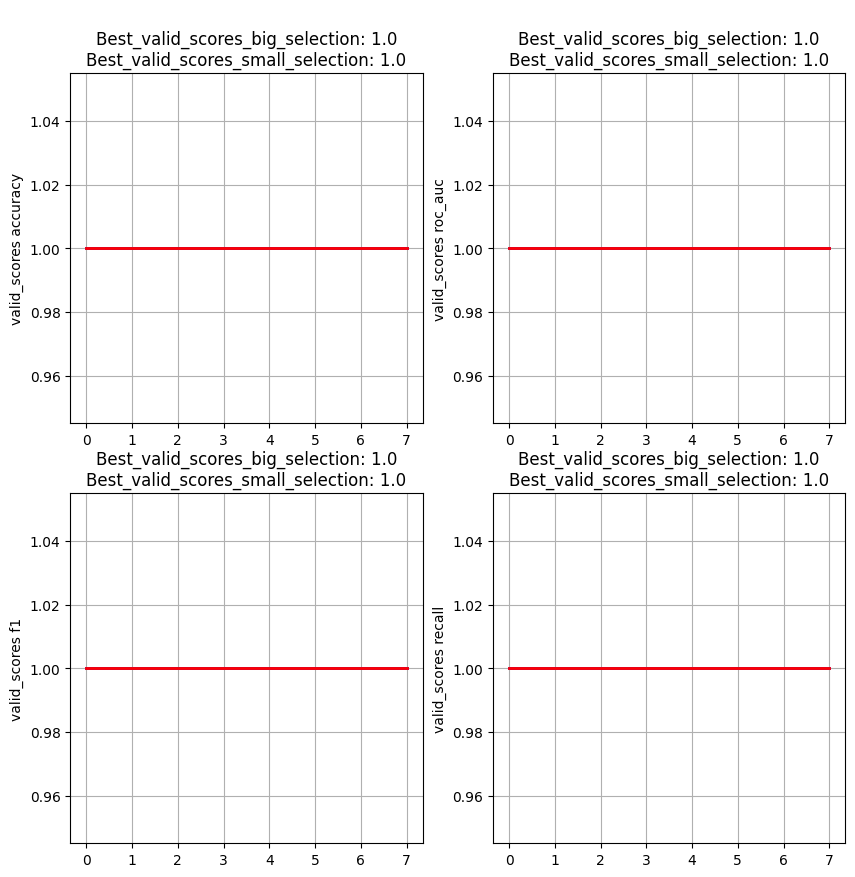

2 ) model learning: DecisionTreeClassifier(random_state=125)
roc_auc_score:  1.0
classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



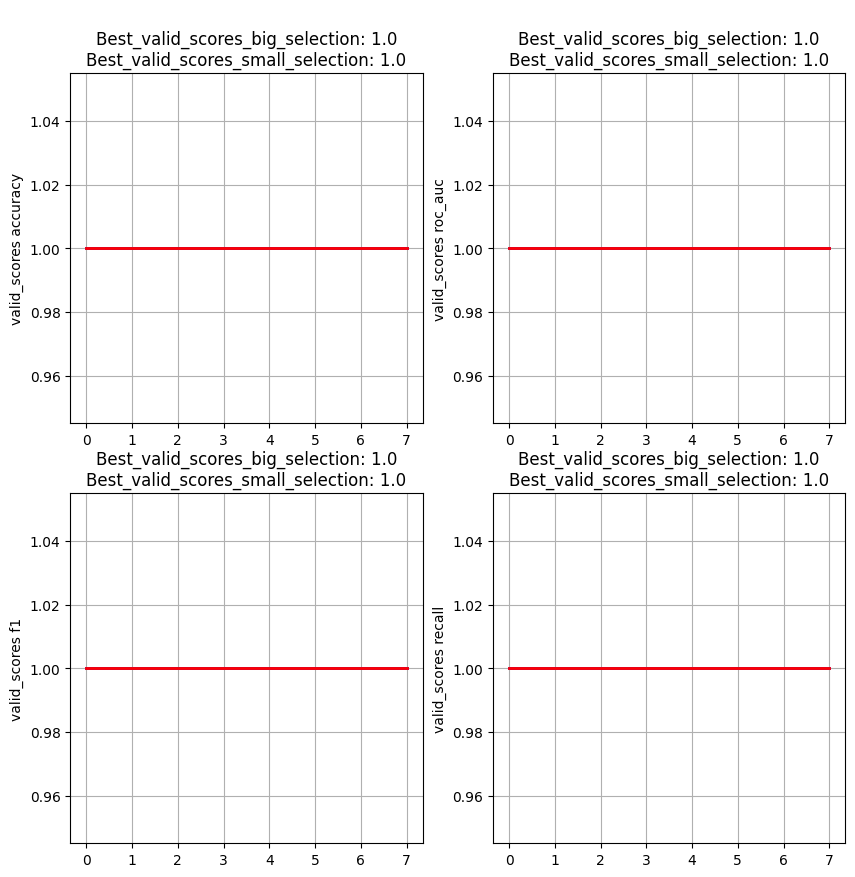

3 ) model learning: SVC(random_state=125)
roc_auc_score:  0.95
classification_report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        15
         1.0       1.00      0.90      0.95        10

    accuracy                           0.96        25
   macro avg       0.97      0.95      0.96        25
weighted avg       0.96      0.96      0.96        25



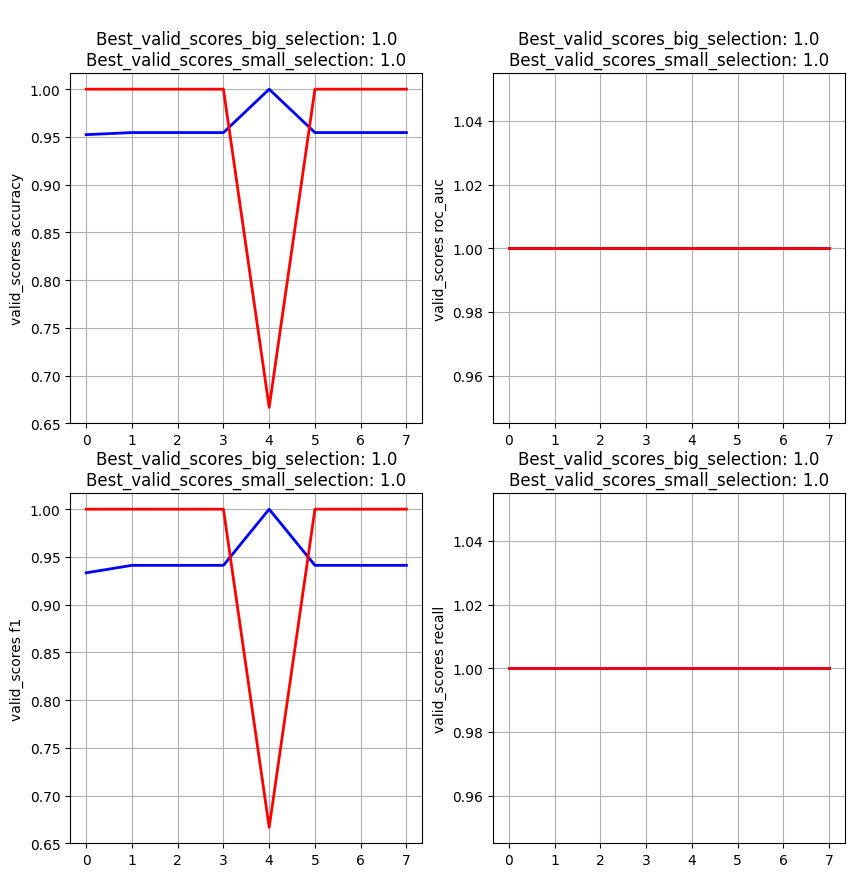

4 ) model learning: RandomForestClassifier(random_state=125)
roc_auc_score:  1.0
classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



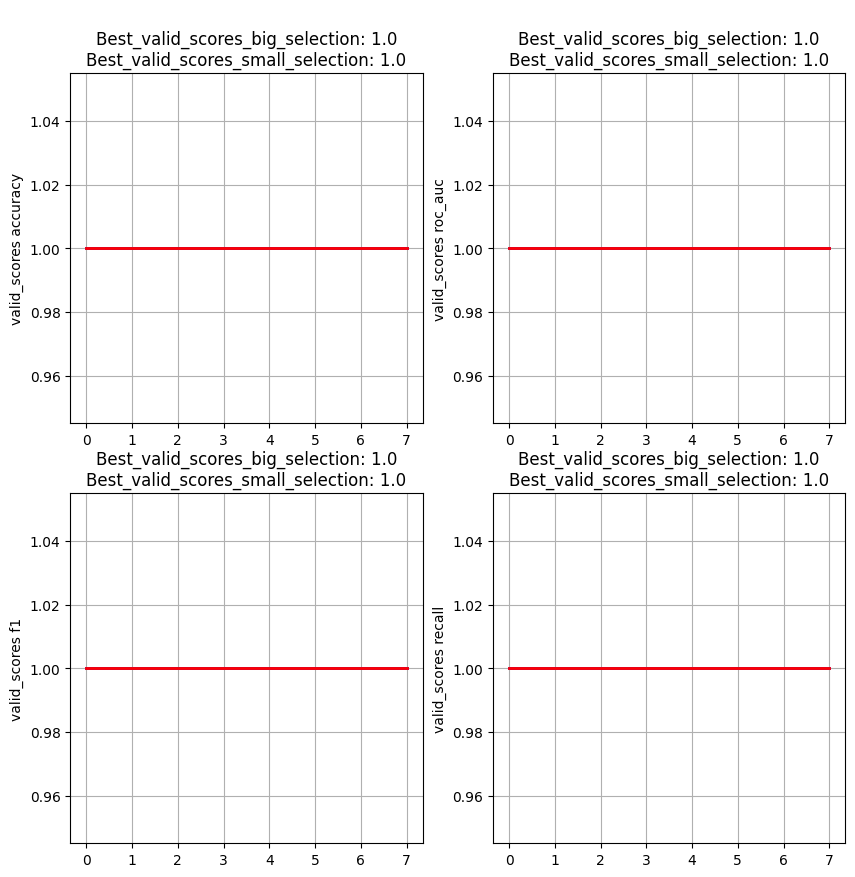

Result Search Best Model:  RandomForestClassifier(random_state=125) roc_auc_score: 1.0


In [16]:
max_score = 0
for j in range(len(MODELS)):
    if "random_state" in list(MODELS[j]().get_params().keys()):
        model = MODELS[j](random_state=RANDOM_STATE)
    else:
        model = MODELS[j]()
    print(j+1,") model learning:", model)
    model.fit(x_train, y_train);
    predict = model.predict(x_test)
    score_value = roc_auc_score(predict, y_test)
    print("roc_auc_score: ", score_value)
    print("classification_report:\n", classification_report(predict, y_test))

    plt.figure(figsize=(10,10))
    for i in range(0, len(METRICS)):
        plt.subplot(2,2,i+1)
        plt.grid(True)
        Print_REsult_scoring_metric(model,x_test,y_test,8,RANDOM_STATE,METRICS[i])
        plt.xlabel("")
    plt.show()
    
    if i<1 or max_score<=score_value:
        max_score = score_value
        model_best = model
print("Result Search Best Model: ", model_best, "roc_auc_score:", max_score)

Как видим из данных полученных исследований наиболее подходящей моделью оказалась RandomForestClassifier по коду, а по взгляду на результаты обучения моделей можно рассматривать для решения данной задачи и все остальные, кроме модели SVC она показала себя хуже. Хотя все это рассматривается конкретно на данной выборке, поэтому при рассмотре другой может все и поменятся. Поэтому и было написано выше отсеивание по метрике roc_auc для определения наилучшей модели на других сгенерированных выборок обучения и тестирования.

## Вывод итоговых данных :

Применим данную модель на неизвестных данных data_nan и проверим выполняются ли 2-ве закономерности:
1) Пациентов которые уже не смогли пережить данный период, то в alive-at-1 уже не может стоять пережил.

2) А вот при still-alive равному выжил и alive-at-1 равному не выжил, вполне возможно. Что говорит нам о том что если пациент пережил период наблюдений, не гарантирует о том что пациент прожил после этого более года.

In [17]:
data_res = data_nan.drop(["alive-at-1"], axis=1).values
data_nan["alive-at-1"] = model_best.predict(data_res)
res_1 = data_nan
print("check validation result alive-at-1 for data_nan[\"still-alive\"]==0: ", set(data_nan[data_nan["still-alive"]==0]["alive-at-1"]))
print("check validation result alive-at-1 for data_nan[\"still-alive\"]==1: ", set(data_nan[data_nan["still-alive"]==1]["alive-at-1"]))
display(data_nan)

check validation result alive-at-1 for data_nan["still-alive"]==0:  {0.0}
check validation result alive-at-1 for data_nan["still-alive"]==1:  {0.0, 1.0}


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
24,48.00,0.0,64.0,0.0,0.190,5.90,3.48,10.00,1.110,0.0
25,29.00,0.0,54.0,0.0,0.300,7.00,3.85,10.00,1.667,0.0
26,29.00,0.0,35.0,0.0,0.300,5.00,4.17,14.00,1.000,0.0
27,29.00,0.0,55.0,0.0,0.205,7.00,4.65,2.00,1.000,0.0
28,0.25,1.0,75.0,0.0,0.205,11.00,4.65,14.00,1.000,1.0
30,1.00,1.0,65.0,0.0,0.150,11.00,5.05,10.00,1.000,1.0
31,1.00,1.0,52.0,1.0,0.170,17.20,5.32,14.00,1.170,1.0
32,3.00,1.0,62.0,0.0,0.205,12.00,4.65,6.00,3.000,1.0
33,27.00,0.0,47.0,0.0,0.400,5.12,3.10,12.00,1.000,0.0
39,31.00,0.0,80.0,0.0,0.410,5.40,4.36,14.00,1.000,0.0


Как видно данные заполнены и запомнены в переменной res_1 и наши закономерности выполняются

## По закономерностям:

По результату описанному выше можно сделать предобработку данных чуть иначе, а и менно бляагодаря найденным 2-м закономерностям, которые подтвердились в первом результате res_1. А именно присвоем столбцу alive-at-1 значения 0 в строках где still-alive == 0. Проведем шаги описанные выше еще раз и сравним полученный результат с предыдущим.

1 ) model learning: LogisticRegression(random_state=125)
roc_auc_score:  1.0
classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        27
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



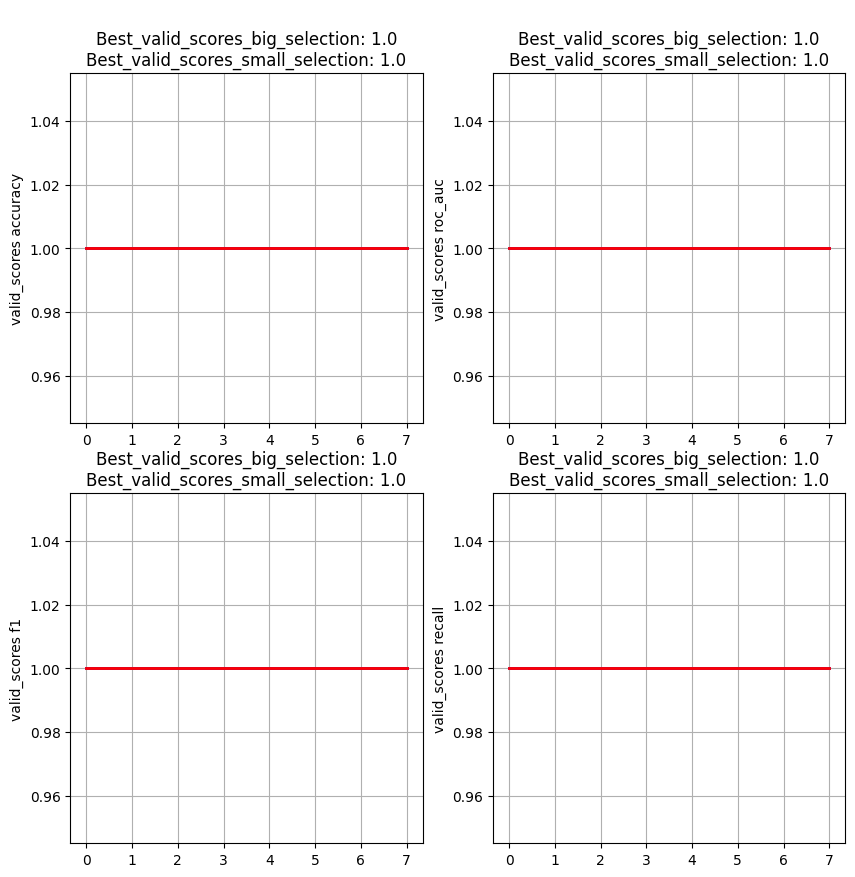

2 ) model learning: DecisionTreeClassifier(random_state=125)
roc_auc_score:  1.0
classification_report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        27
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



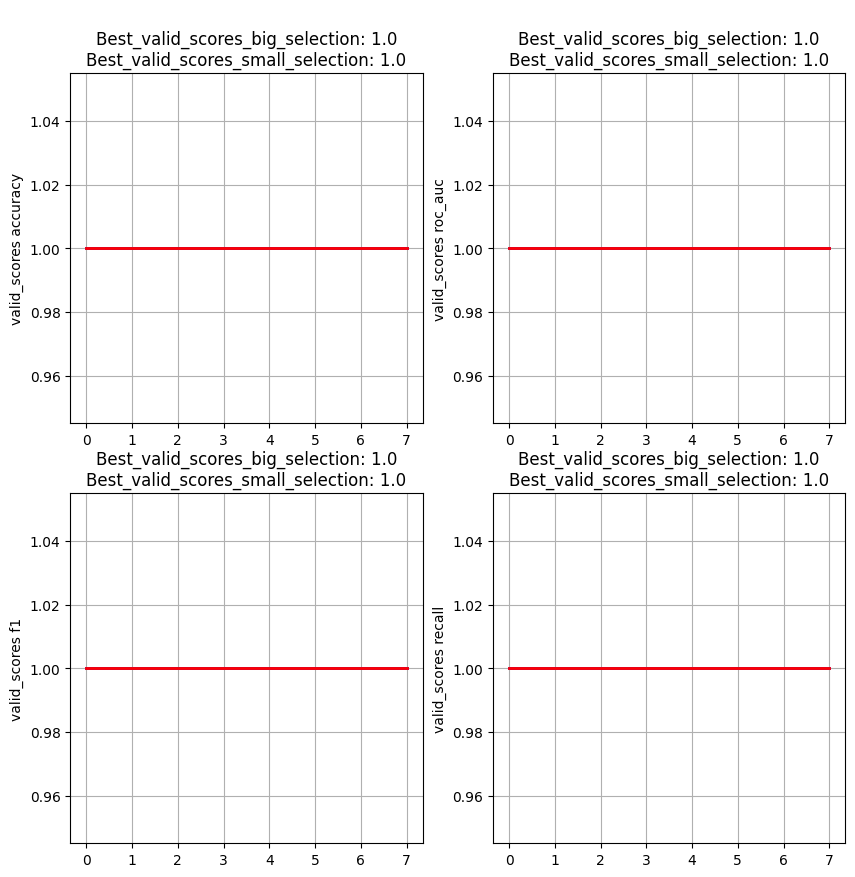

3 ) model learning: SVC(random_state=125)
roc_auc_score:  0.9500000000000001
classification_report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        30
         1.0       0.75      1.00      0.86         9

    accuracy                           0.92        39
   macro avg       0.88      0.95      0.90        39
weighted avg       0.94      0.92      0.93        39



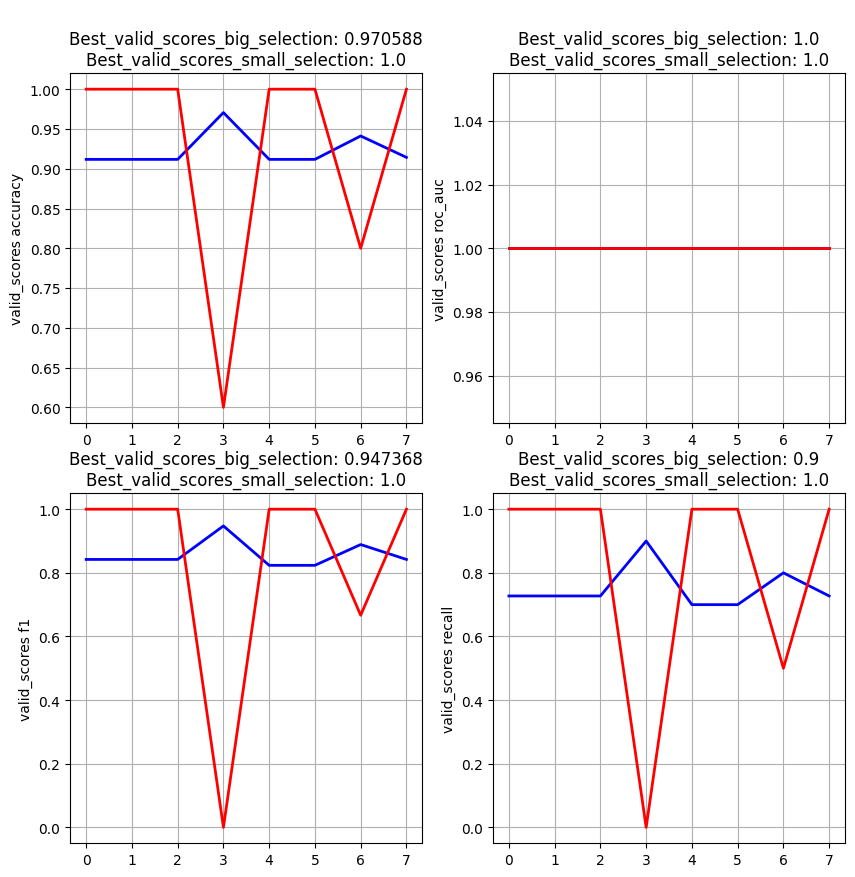

4 ) model learning: RandomForestClassifier(random_state=125)
roc_auc_score:  0.9821428571428572
classification_report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98        28
         1.0       0.92      1.00      0.96        11

    accuracy                           0.97        39
   macro avg       0.96      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39



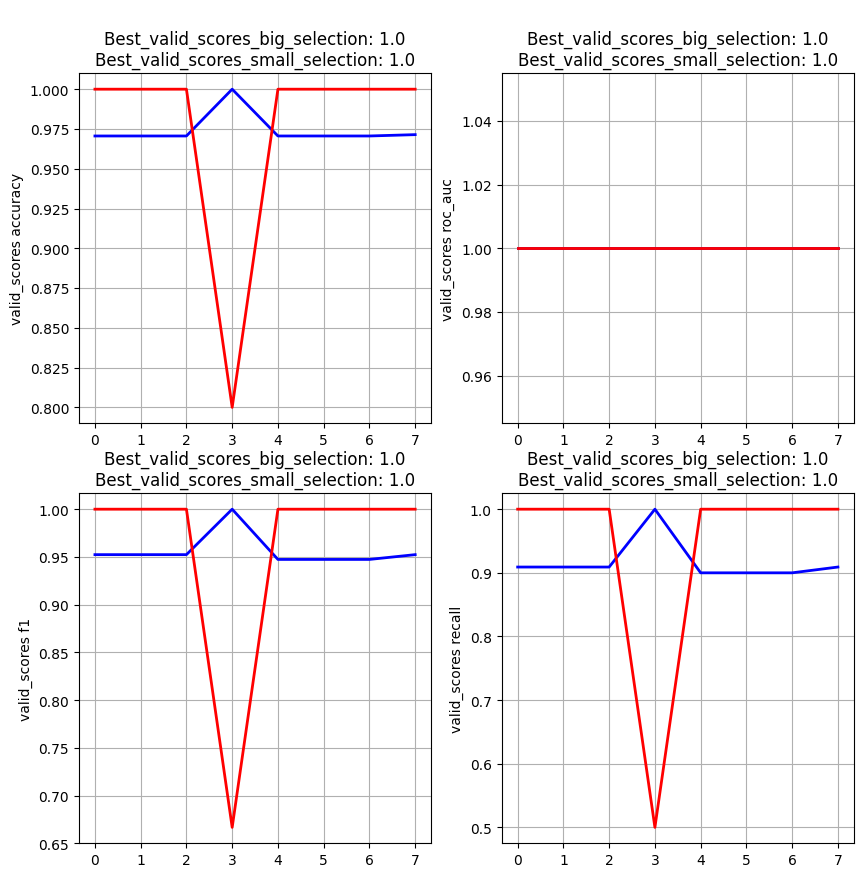

Result Search Best Model:  DecisionTreeClassifier(random_state=125) roc_auc_score: 1.0
check validation result alive-at-1 for data_nan["still-alive"]==0:  set()
check validation result alive-at-1 for data_nan["still-alive"]==1:  {0.0, 1.0}


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
28,0.25,1.0,75.0,0.0,0.205,11.0,4.65,14.00,1.00,1.0
30,1.00,1.0,65.0,0.0,0.150,11.0,5.05,10.00,1.00,1.0
31,1.00,1.0,52.0,1.0,0.170,17.2,5.32,14.00,1.17,1.0
32,3.00,1.0,62.0,0.0,0.205,12.0,4.65,6.00,3.00,1.0
44,2.00,1.0,67.0,1.0,0.440,9.0,3.96,17.50,1.45,1.0
63,0.50,1.0,59.0,0.0,0.130,16.4,4.96,17.83,1.37,1.0
66,0.75,1.0,50.0,0.0,0.140,11.4,4.75,10.00,2.50,1.0
76,0.25,1.0,68.0,0.0,0.220,21.7,4.85,15.00,1.15,1.0
86,1.00,1.0,73.0,0.0,0.050,14.8,4.14,15.50,1.41,1.0
87,21.00,1.0,70.0,1.0,0.160,19.2,5.25,11.00,1.00,0.0


In [18]:
df = read_data("echocardiogram_edit.csv")
data, data_nan = pred_procesing_data_2(df)

if "alive-at-1" in data.columns:
    Y = data.pop("alive-at-1")
X = data
x_train, x_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.33, random_state=RANDOM_STATE)

max_score = 0
for j in range(len(MODELS)):
    if "random_state" in list(MODELS[j]().get_params().keys()):
        model = MODELS[j](random_state=RANDOM_STATE)
    else:
        model = MODELS[j]()
    print(j+1,") model learning:", model)
    model.fit(x_train, y_train);
    predict = model.predict(x_test)
    score_value = roc_auc_score(predict, y_test)
    print("roc_auc_score: ", score_value)
    print("classification_report:\n", classification_report(predict, y_test))

    plt.figure(figsize=(10,10))
    for i in range(0, len(METRICS)):
        plt.subplot(2,2,i+1)
        plt.grid(True)
        Print_REsult_scoring_metric(model,x_test,y_test,8,RANDOM_STATE,METRICS[i])
        plt.xlabel("")
    plt.show()
    
    if i<1 or max_score<=score_value:
        max_score = score_value
        model_best = model
print("Result Search Best Model: ", model_best, "roc_auc_score:", max_score)

data_res = data_nan.drop(["alive-at-1"], axis=1).values
data_nan["alive-at-1"] = model_best.predict(data_res)
res_2 = data_nan
print("check validation result alive-at-1 for data_nan[\"still-alive\"]==0: ", set(data_nan[data_nan["still-alive"]==0]["alive-at-1"]))
print("check validation result alive-at-1 for data_nan[\"still-alive\"]==1: ", set(data_nan[data_nan["still-alive"]==1]["alive-at-1"]))
display(data_nan)

Как видим мы изменили наши известные значения и уменьшили неизвестные до того что наша модель должна определить лишь данные в которых известно что пациент точно выжил после периода наблюдения.

В результате получили совершенно другие результаты, а именно наилучшей моделью оказалась DecisionTreeClassifier.

Сравним полученные данные из res_1 и res_2. Т.к. res_1 содержит данные still-alive == 0, опустим их

In [19]:
new_res_1 = res_1.loc[res_1["still-alive"]==1]
new_res_1

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
28,0.25,1.0,75.0,0.0,0.205,11.0,4.65,14.00,1.00,1.0
30,1.00,1.0,65.0,0.0,0.150,11.0,5.05,10.00,1.00,1.0
31,1.00,1.0,52.0,1.0,0.170,17.2,5.32,14.00,1.17,1.0
32,3.00,1.0,62.0,0.0,0.205,12.0,4.65,6.00,3.00,1.0
44,2.00,1.0,67.0,1.0,0.440,9.0,3.96,17.50,1.45,1.0
63,0.50,1.0,59.0,0.0,0.130,16.4,4.96,17.83,1.37,1.0
66,0.75,1.0,50.0,0.0,0.140,11.4,4.75,10.00,2.50,1.0
76,0.25,1.0,68.0,0.0,0.220,21.7,4.85,15.00,1.15,1.0
86,1.00,1.0,73.0,0.0,0.050,14.8,4.14,15.50,1.41,1.0
87,21.00,1.0,70.0,1.0,0.160,19.2,5.25,11.00,1.00,0.0


сравним полученные значения по тойже метрике roc_auc:

In [20]:
print(roc_auc_score(new_res_1["alive-at-1"].values, res_2["alive-at-1"].values))

1.0


Как видим данные предсказаны верно и мы можем c увереностью заявить что они востновлены при помощи моделей RandomForestClassifier и DecisionTreeClassifier с точностью около 100% по метрике roc_auc

## Вывод:

Во время выполнения лабораторной работы были проведены следующие действия:

1) Проанализированы и обработаны исходные данные

2) была выделена целевая переменная alive-at-1

3) На основе данных и целевой переменной сформулированая задача: восстановить потерянные данные в столбце alive-at-1 при помощи обученной модели 

4) Были рассмотрены 4 модели классификации LogisticRegression, DecisionTreeClassifier, SVC, RandomForestClassifier и проанализированы 2 случая обучения

Врезультате наиболее подходящими моделями: 
* 1-ом случае оказалась модель RandomForestClassifier
* 2-ом случае оказалась модель DecisionTreeClassifier

И получилось воостановить неизвестные данные с точностью около 100% по метрике roc_auc, которые указаны ниже:

In [21]:
res_1

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
24,48.00,0.0,64.0,0.0,0.190,5.90,3.48,10.00,1.110,0.0
25,29.00,0.0,54.0,0.0,0.300,7.00,3.85,10.00,1.667,0.0
26,29.00,0.0,35.0,0.0,0.300,5.00,4.17,14.00,1.000,0.0
27,29.00,0.0,55.0,0.0,0.205,7.00,4.65,2.00,1.000,0.0
28,0.25,1.0,75.0,0.0,0.205,11.00,4.65,14.00,1.000,1.0
30,1.00,1.0,65.0,0.0,0.150,11.00,5.05,10.00,1.000,1.0
31,1.00,1.0,52.0,1.0,0.170,17.20,5.32,14.00,1.170,1.0
32,3.00,1.0,62.0,0.0,0.205,12.00,4.65,6.00,3.000,1.0
33,27.00,0.0,47.0,0.0,0.400,5.12,3.10,12.00,1.000,0.0
39,31.00,0.0,80.0,0.0,0.410,5.40,4.36,14.00,1.000,0.0
